#### Questions

1. how to deal with perfect separation
2. what if log odds or logit does not cross 0 for continuous variable (how to categorize continuous variable)
3. how to pool categorical variable
4. how to visually check if some predictor should be added / removed
5. high fico confounding with book tier
6. for significance check, shall I only focus on the major group / response variable value?

In [61]:
import sys
import os
import numpy as np
import pandas as pd

sys.path.append(os.path.dirname(os.path.realpath(os.getcwd())))
sys.path.append(os.path.dirname(os.path.dirname(os.path.realpath(os.getcwd()))))


from PortfolioEDA import PortfolioEDA
from TransitionMatrixModelingManagement import TransitionMatrixModelingManagement

In [62]:
loanHist = pd.read_csv('../../Data/loantape.csv')
loanHist = loanHist[loanHist.LoanStatus2_Lag1 == 'LateDQ']

#### Data Cleaning and Enrichment

In [63]:
loanHist = loanHist.sort_values(by=['ApplicationID', 'Snapshotdt'], ascending=[True, True])

# status indicator : map status to 0, 1, 2, 3, 4
statusMap = {'Current': 0, 'EarlyDQ': 1, 'LateDQ': 2, 'CO': 3, 'Prepaid': 4}
loanHist['LoanStatus2_Ind'] = loanHist['LoanStatus2'].replace(statusMap)

# remit / snapshot date in quarter
bins, labels = [0, 3, 6, 9, 12], [1, 2, 3, 4]
loanHist['remitQtr'] = pd.cut(pd.to_datetime(loanHist['Snapshotdt']).dt.month, bins=bins, labels=labels, right=True)

loanHist['UPB_lag1']= loanHist.groupby('ApplicationID')['UPB'].shift(1)

loanHist['factor'] = loanHist['UPB'] / loanHist['OriginalAmtFinanced']
loanHist['factor_lag1'] = loanHist.groupby('ApplicationID')['factor'].shift(1)
loanHist = loanHist[~loanHist['factor_lag1'].isna()]




#### Portfolio EDA

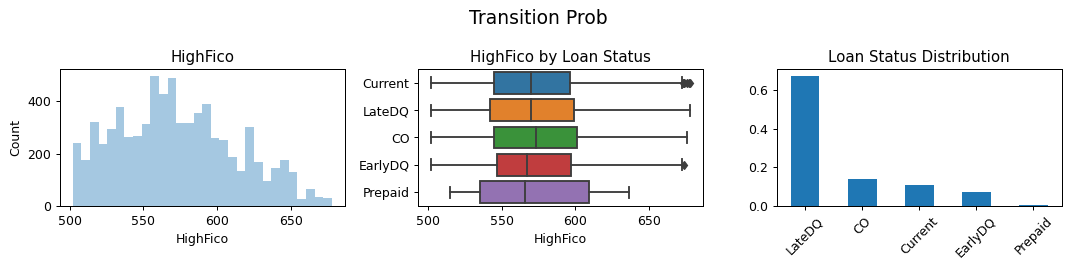

In [18]:
# ** Portfolio EDA instance
portfolioEDA = PortfolioEDA.PortfolioEDA(loanHist, 
                    colNames = {"date":'Snapshotdt', 
                                "loanStatus":'LoanStatus2',
                                "eopBal":'UPB'})

portfolioEDA.portfolioTM.plotStatusDist('HighFico', continuous=True, excludeExtreme = {'lowerBound':0.01, 'upperBound':0.99})

In [ ]:
transitionModeling.displayLogitOnSingle('HighFico', binsArg={"m": 4})

#### Transition Matrix Modeling

In [64]:
transitionModeling = TransitionMatrixModelingManagement(
    loanHist, responseVariable="LoanStatus2_Ind"
)


transitionModeling.setInputList(
    [
        "PTICore", "LTVCore", "BookTier", "MOB", "RemainingTerm", "factor_lag1", "NumberOfExtensions", "CurrentRate", "DTICore", "ModelYr", "BookValue", "OriginalAmtFinanced",
        "OriginalTerm", "BookNewUsed", "BookMileage", "HighFico",  "remitQtr",  'UPB_lag1'
    ],
    "covariateList",
    "base",
)

transitionModeling.setInputList(
    ["BookTier", "BookNewUsed", "remitQtr"], "tuningVariableList", "categoricalList"
)

#### Step 1: run response against all potential preditors as univariate model
- choose p value <.25
- if p is nan (probably due to perfect separation, drop it at the moment)

In [ ]:
transitionModeling.loopThroughUnitvariate()

In [10]:
print(transitionModeling.univariateRunSummary[['Variable', 'p-value']])

               Variable   p-value
0               PTICore   0.01675
1               LTVCore  0.000003
2              BookTier  0.001102
3                   MOB       0.0
4         RemainingTerm       0.0
5           factor_lag1       0.0
6    NumberOfExtensions       0.0
7           CurrentRate       0.0
8               DTICore   0.00082
9               ModelYr  0.000024
10            BookValue       NaN
11  OriginalAmtFinanced       NaN
12         OriginalTerm  0.185195
13          BookNewUsed  0.005781
14          BookMileage       NaN
15             HighFico       NaN
16             remitQtr  0.000001
17             UPB_lag1       NaN


In [65]:
transitionModeling.updateInputList({"remove": ["BookValue", "OriginalAmtFinanced", "BookMileage", "HighFico", "UPB_lag1"]},
                                   "covariateList", "base")


In [66]:
transitionModeling.runModel(targetCovariateGroup="base")

Optimization terminated successfully.
         Current function value: 0.490728
         Iterations: 809
         Function evaluations: 815
         Gradient evaluations: 815


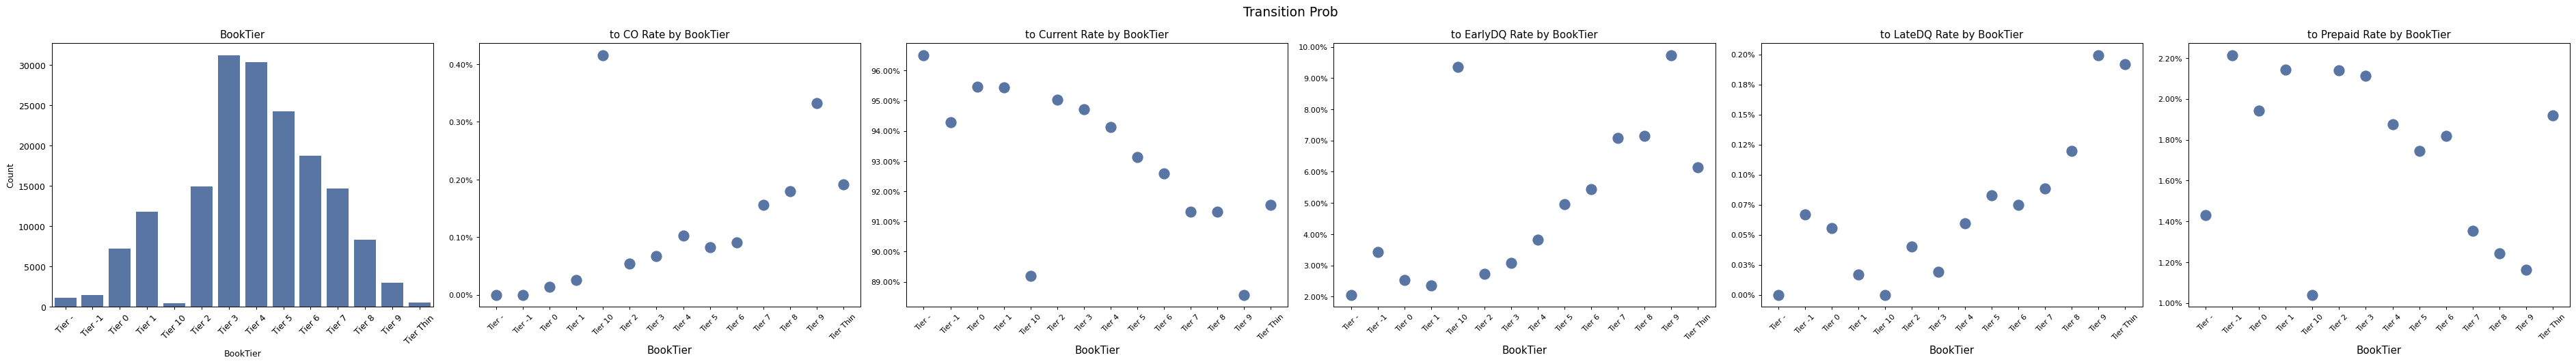

In [13]:
portfolioEDA.portfolioTM.plotStatusDist('BookTier', continuous=False, excludeExtreme = {})

In [11]:
print(transitionModeling.univariateRunSummary[transitionModeling.univariateRunSummary['Variable'] == 'BookTier']['modelRes'].values[0].summary())

                          MNLogit Regression Results                          
Dep. Variable:        LoanStatus2_Ind   No. Observations:               167946
Model:                        MNLogit   Df Residuals:                   167890
Method:                           MLE   Df Model:                           52
Date:                Fri, 22 Sep 2023   Pseudo R-squ.:                 0.01303
Time:                        14:06:00   Log-Likelihood:                -46741.
converged:                       True   LL-Null:                       -47358.
Covariance Type:            nonrobust   LLR p-value:                3.680e-224
 LoanStatus2_Ind=1       coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
BookTier_Tier -1       0.4781      0.251      1.906      0.057      -0.014       0.970
BookTier_Tier 0        0.1673      0.219      0.763      0.446      -0.263       0.597
BookTier_Tier 1     

#### pool categorical
- BookTier
- remitQtr

In [67]:

bookTierPooling = {}
for item in ["Tier -", "Tier -1", "Tier 0", "Tier 1","Tier 2", "Tier 3"]:
    bookTierPooling[item] = "Tier-1"

for item in ["Tier 4", "Tier 5", "Tier 6", "Tier 7", "Tier 8" "Tier Thin"]:
    bookTierPooling[item] = "Tier-2"
    
for item in ["Tier 9", "Tier 10"]:
    bookTierPooling[item] = "Tier-3"


# bookTierPooling = {}
# for item in ["Tier 1","Tier 2","Tier 0","Tier -"]:
#     bookTierPooling[item] = "Tier-1"

# for item in ["Tier 4", "Tier -1", "Tier 3"]:
#     bookTierPooling[item] = "Tier-2"

# for item in ["Tier 6", "Tier 5", "Tier Thin"]:
#     bookTierPooling[item] = "Tier-3"

# for item in ["Tier 7", "Tier 8"]:
#     bookTierPooling[item] = "Tier-4"
    
# for item in ["Tier 9", "Tier 10"]:
#     bookTierPooling[item] = "Tier-5"
    

transitionModeling.poolingCategorical("BookTier", "BookTierPooling", bookTierPooling)
transitionModeling.updateInputList(
    {"add": ["BookTierPooling"], "remove": ["BookTier"]}, "covariateList", "base"
)


In [68]:
remitQtrPooling = {}
for item in [1,2]:
    remitQtrPooling[item] = "remit1H"
    
for item in [3,4]:
    remitQtrPooling[item] = "remit2H"

transitionModeling.poolingCategorical("remitQtr", "remitQtrPooling", remitQtrPooling)
transitionModeling.updateInputList(
    {"add": ["remitQtrPooling"], "remove": ["remitQtr"]}, "covariateList", "base"
)

In [69]:
transitionModeling.runModel(targetCovariateGroup="base")
print(transitionModeling.baseRes.summary())

Optimization terminated successfully.
         Current function value: 0.500100
         Iterations: 522
         Function evaluations: 529
         Gradient evaluations: 529
                          MNLogit Regression Results                          
Dep. Variable:        LoanStatus2_Ind   No. Observations:                 7372
Model:                        MNLogit   Df Residuals:                     7312
Method:                           MLE   Df Model:                           56
Date:                Sat, 23 Sep 2023   Pseudo R-squ.:                  0.4961
Time:                        19:29:16   Log-Likelihood:                -3686.7
converged:                       True   LL-Null:                       -7317.0
Covariance Type:            nonrobust   LLR p-value:                     0.000
      LoanStatus2_Ind=1       coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
PTICore  

#### Step 2 / 3
- check unsignificant variable in covariate model
- check each removal of covariate impact on chi2 (overall significance) and params change (confounding check) 

In [ ]:
baseModelInput = {"modelRes":transitionModeling.baseRes, "covariate": transitionModeling.covariateList["base"]}.copy()
testModelYr = transitionModeling.runAgainstVariate(baseModelInput, "ModelYr", remove = True)
# print(testModelYr['stats'])
# ** ModelYr: significant on chi2 test; also has confounding impact. keep the variable

# testHighFico = transitionModeling.runAgainstVariate(baseModelInput, "HighFico", remove = True)
# ** HighFico: significant on chi2 test; not major confounding impact on to 0 model, but meaningful on to 1 model. keep the variable

# testBookNewUsed = transitionModeling.runAgainstVariate(baseModelInput, "BookNewUsed", remove = True)
# ** BookNewUsed: significant on chi2 test; also has confounding impact. keep the variable


#### Step 4
- add variable excluded from step 1 and check 1) their significance and 2) confounding
- DTICore
- BookValue
- OriginalAmtFinanced
- BookMileage

In [ ]:
# baseModelInput = {"modelRes":transitionModeling.baseRes, "covariate": transitionModeling.covariateList["base"]}.copy()

# testDTICore = transitionModeling.runAgainstVariate(baseModelInput, "DTICore", remove = False)
# print(testDTICore['stats'])
# ** DTICore: chi2 p value not significnat; has somewhat confounding impact, decided not to add DTI

# testBookValue = transitionModeling.runAgainstVariate(baseModelInput, "BookValue", remove = False)
# ** BookValue: add BookValue will make the new model perfect separation; not to add it


# testOriginalAmtFinanced = transitionModeling.runAgainstVariate(baseModelInput, "OriginalAmtFinanced", remove = False)
# ** OriginalAmtFinanced: add OriginalAmtFinanced will make the new model perfect separation; not to add it


# testBookMileage = transitionModeling.runAgainstVariate(baseModelInput, "BookMileage", remove = False)
# ** BookMileage: chi2 test significant; has confounding impact. add the variable



In [37]:
print(transitionModeling.baseRes.summary())


                          MNLogit Regression Results                          
Dep. Variable:        LoanStatus2_Ind   No. Observations:                 7372
Model:                        MNLogit   Df Residuals:                     7260
Method:                           MLE   Df Model:                          108
Date:                Sat, 23 Sep 2023   Pseudo R-squ.:                  0.5056
Time:                        19:23:15   Log-Likelihood:                -3617.6
converged:                       True   LL-Null:                       -7317.0
Covariance Type:            nonrobust   LLR p-value:                     0.000
 LoanStatus2_Ind=4       coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
PTICore               -3.0134      1.928     -1.563      0.118      -6.793       0.766
LTVCore               -0.9382      0.394     -2.380      0.017      -1.711      -0.166
MOB                 

#### Step 5: check continuous variable for non-linearity


#### Step 6: check interaction term

In [69]:
transitionModeling.updateInputList(
    {"add": [["RemainingTerm","factor_lag1"],["MOB","RemainingTerm"]]},
    "tuningVariableList",
    "interaction",
)
transitionModeling.addInteraction()

transitionModeling.setInputList(
    transitionModeling.covariateList['base'] + ['RemainingTerm x factor_lag1','MOB x RemainingTerm'],
    "covariateList",
    "base",
)
transitionModeling.runModel(targetCovariateGroup="base")

Optimization terminated successfully.
         Current function value: 0.220611
         Iterations: 924
         Function evaluations: 957
         Gradient evaluations: 957


#### Train and Split into training and test data set
- use final step covariate model to train
- test on test data set
- use AUC to summarize good of fitness

In [15]:
transitionModeling.runTrainingTest()
print(transitionModeling.trainingTestRes['AUC(ovr)'])
print(transitionModeling.trainingTestRes['AUC(ovo)'])

# .78
# .75

0.903233223296865
0.851157142378511


In [70]:
savePkl = {"model":transitionModeling.baseRes}.copy()

import pickle
with open('../SavedModels/fromLDModel.pickle', 'wb') as handle:
    pickle.dump(savePkl, handle, protocol=pickle.HIGHEST_PROTOCOL)
